Saved rl_results/video_episode_1499.mp4


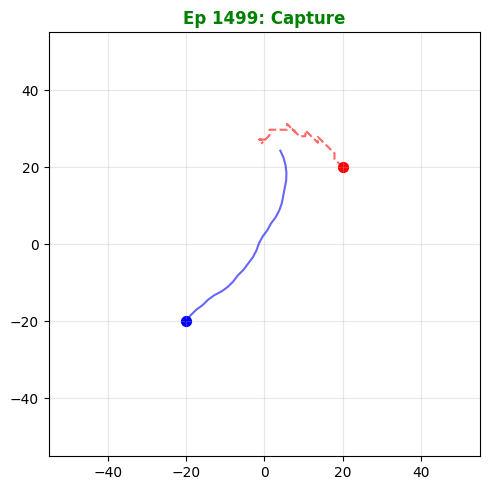

Ep 1499 | Rw: 557.39 | Len: 28 | Wall: 0

Training complete in 988s
Models and metrics saved.
Metrics dashboard saved to rl_results/metrics_dashboard.png


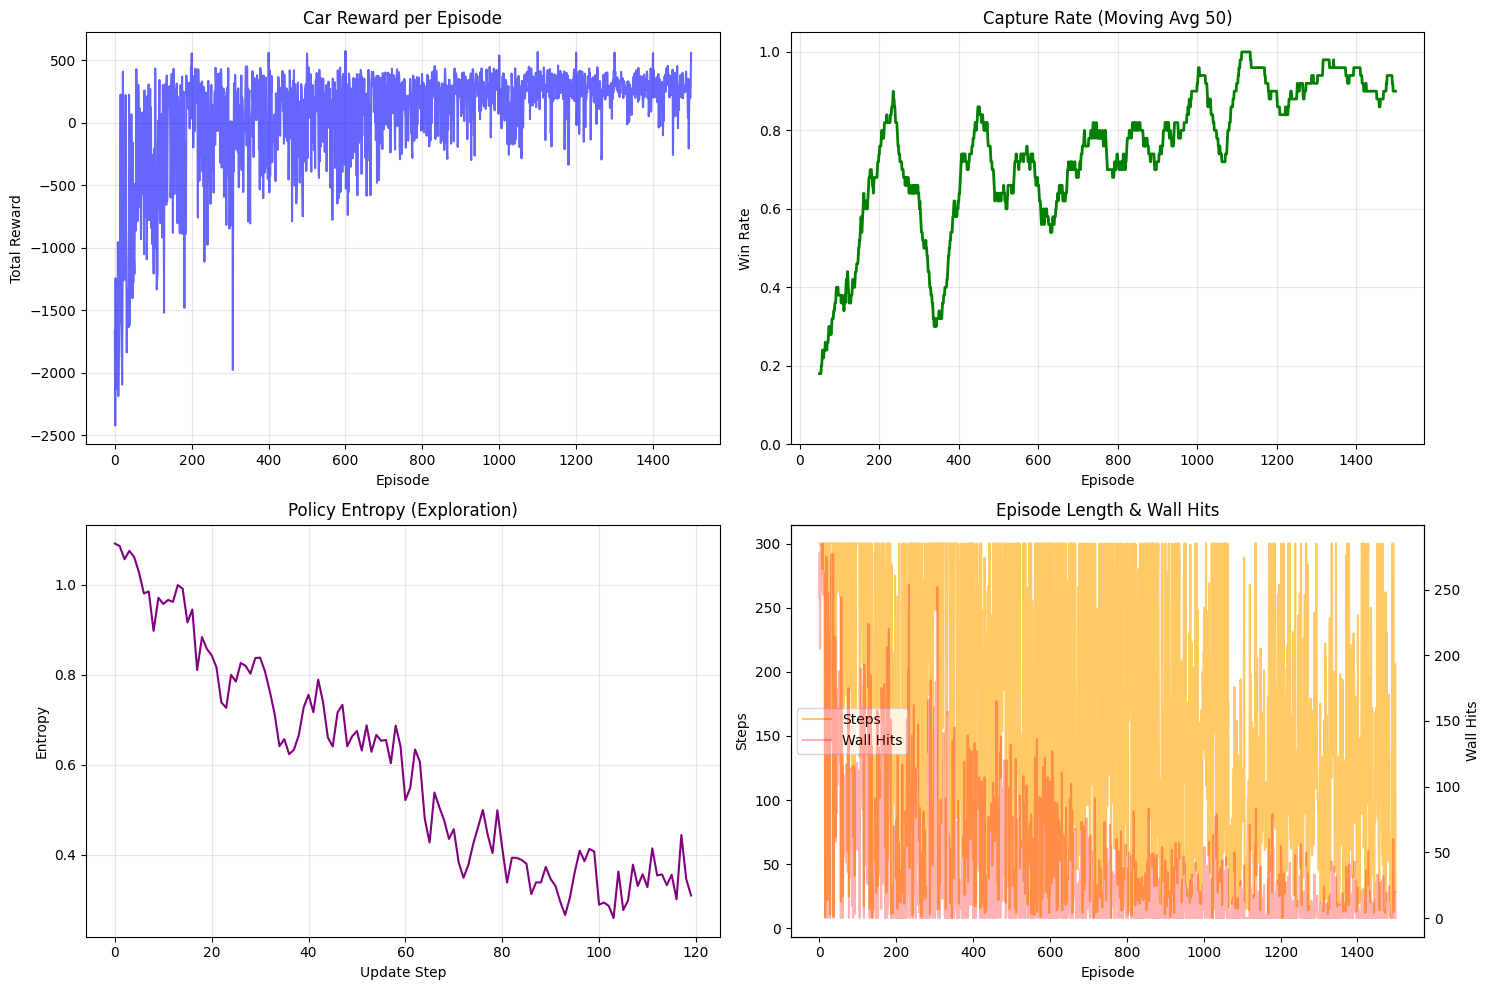

Summary plot saved.


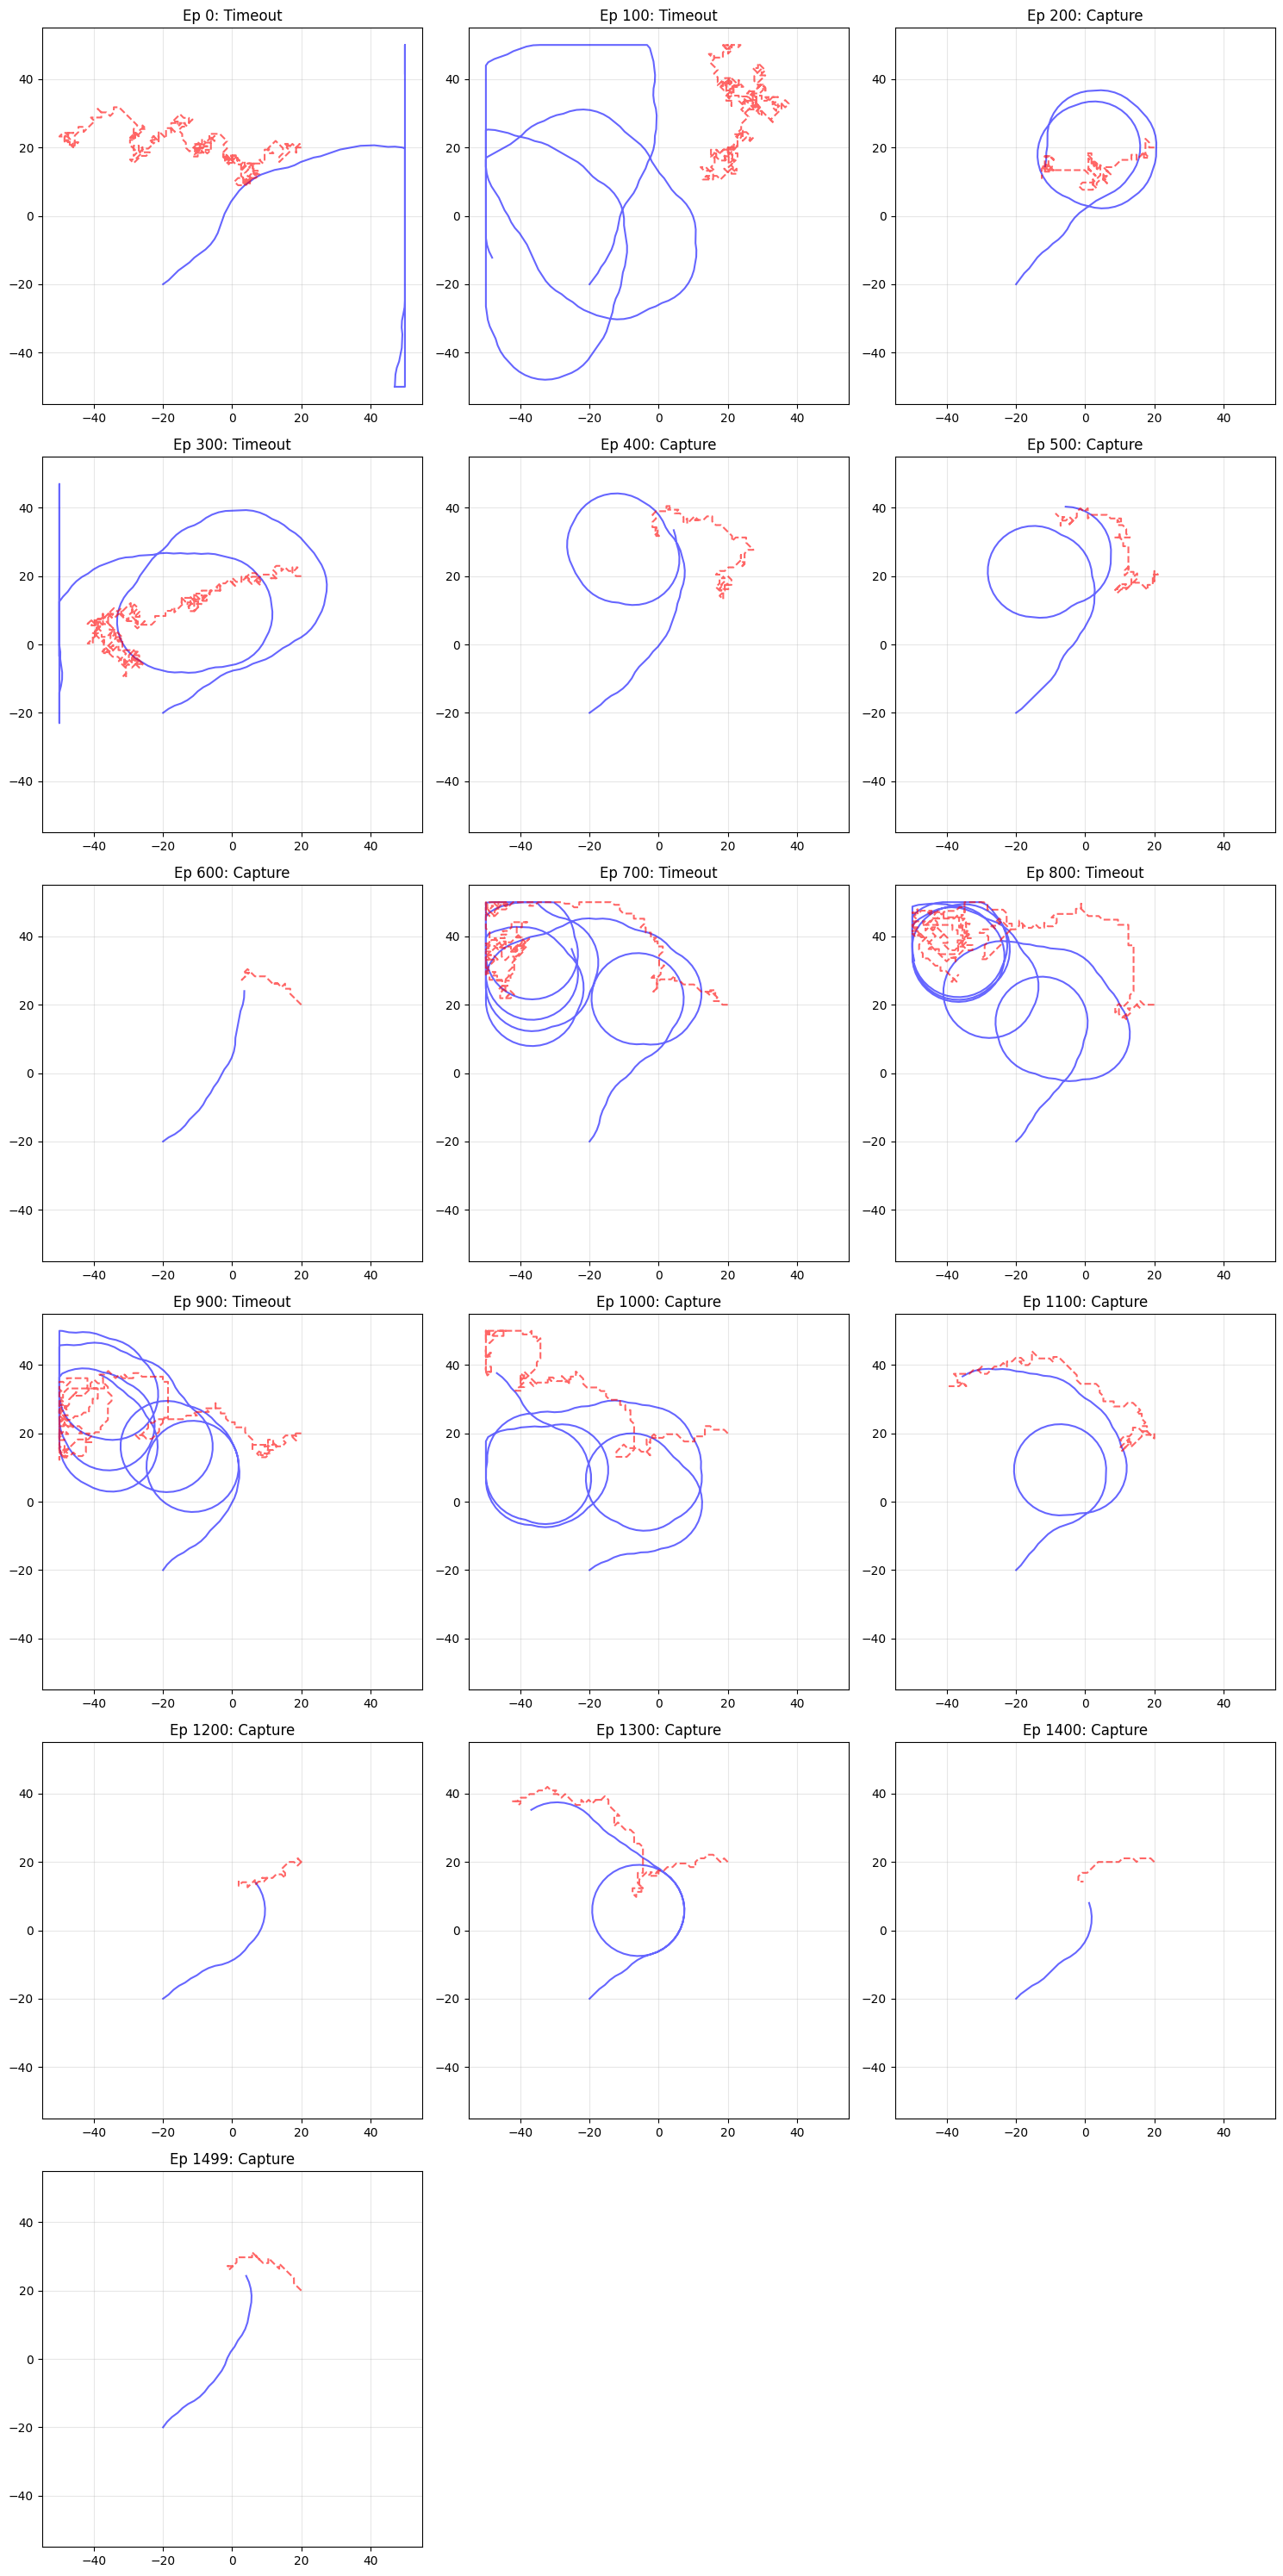

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display, clear_output
import random
import math
import time
import pickle
import shutil

# --- 1. SETUP ---
def check_ffmpeg():
    """
    Checks if FFmpeg is installed on the system.
    FFmpeg is required for saving the training visualizations as MP4 videos.
    If not found, attempts to install it via apt-get (Linux).
    """
    if shutil.which('ffmpeg') is None:
        print("Installing FFmpeg...")
        try:
            os.system('apt-get update && apt-get install -y ffmpeg')
        except:
            print("FFmpeg install failed. Video saving might not work.")

# --- 2. NETWORK ---
class ActorCritic(nn.Module):
    """
    A shared Actor-Critic Neural Network.

    Structure:
    - Base: Shared fully connected layers processing the state.
    - Actor Head: Outputs action probabilities (Softmax).
    - Critic Head: Outputs the estimated value of the state (Scalar).
    """
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        # Shared feature extractor
        self.base = nn.Sequential(
            nn.Linear(state_dim, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh()
        )
        # Actor: Outputs probability distribution over actions
        self.actor = nn.Sequential(
            nn.Linear(64, action_dim), nn.Softmax(dim=-1)
        )
        # Critic: Estimates Value V(s)
        self.critic = nn.Linear(64, 1)

    def forward(self, x):
        """Forward pass to get action probs and state value."""
        features = self.base(x)
        return self.actor(features), self.critic(features)

    def get_action(self, state):
        """
        Selects an action during the rollout (interaction) phase.

        Args:
            state (torch.Tensor): Current environment state.

        Returns:
            action: The sampled action index.
            log_prob: Log probability of that action (needed for PPO gradient).
            value: The critic's value estimate.
        """
        with torch.no_grad():
            probs, value = self.forward(state)
            dist = Categorical(probs)
            action = dist.sample()
            return action.item(), dist.log_prob(action), value

    def evaluate(self, state, action):
        """
        Evaluates a batch of states and actions during the PPO update phase.

        Returns:
            action_log_probs: Log probability of the taken actions under the current policy.
            value: Recalculated value estimates.
            dist_entropy: Entropy of the distribution (used for exploration bonus).
        """
        probs, value = self.forward(state)
        dist = Categorical(probs)
        action_log_probs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        return action_log_probs, value, dist_entropy

# --- 3. BUFFER ---
class RolloutBuffer:
    """
    Stores transitions (trajectories) collected during interaction with the environment.
    These are used to calculate advantages and update the PPO agent.
    """
    def __init__(self):
        self.states, self.actions, self.logprobs = [], [], []
        self.rewards, self.is_terminals, self.values = [], [], []

    def clear(self):
        """Clears the buffer after an update step."""
        del self.states[:]; del self.actions[:]; del self.logprobs[:]
        del self.rewards[:]; del self.is_terminals[:]; del self.values[:]

    def add(self, state, action, logprob, reward, done, value):
        """Adds a single transition to the buffer."""
        self.states.append(state.cpu().detach())
        self.actions.append(torch.tensor(action).cpu())
        self.logprobs.append(logprob.cpu().detach())
        self.rewards.append(reward)
        self.is_terminals.append(done)
        self.values.append(value.cpu().detach().squeeze())

# --- 4. PPO AGENT ---
class PPOAgent:
    """
    Proximal Policy Optimization (PPO) Agent.

    Algorithms Implemented:
    - PPO-Clip: Limits the update step size to ensure training stability.
    - GAE (Generalized Advantage Estimation): Reduces variance in advantage calculation.
    """
    def __init__(self, state_dim, action_dim, lr, gamma, K_epochs, eps_clip, gae_lambda=0.95, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma              # Discount factor
        self.eps_clip = eps_clip        # PPO Clipping parameter (e.g., 0.2)
        self.K_epochs = K_epochs        # Number of optimization epochs per batch
        self.gae_lambda = gae_lambda    # GAE smoothing parameter
        self.batch_size = batch_size    # Mini-batch size for updates

        # Current policy
        self.policy = ActorCritic(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

        # Old policy (used for calculating the probability ratio r_t(theta))
        self.policy_old = ActorCritic(state_dim, action_dim).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.buffer = RolloutBuffer()
        self.mse_loss = nn.MSELoss()

    def update(self):
        """
        Main PPO Update Logic:
        1. Calculate GAE (Generalized Advantage Estimation).
        2. Optimize the policy for K epochs using mini-batches.
        3. Update policy_old weights.
        """
        # Return 0,0 if no update happens
        if len(self.buffer.states) == 0: return 0.0, 0.0

        # Prepare Full Batch
        old_states = torch.stack(self.buffer.states).to(self.device)
        old_actions = torch.stack(self.buffer.actions).to(self.device)
        old_logprobs = torch.stack(self.buffer.logprobs).to(self.device)
        old_values = torch.stack(self.buffer.values).to(self.device)

        # --- Compute GAE (Generalized Advantage Estimation) ---
        rewards = []
        gae = 0
        # Iterate backwards through rewards to calculate returns
        for i in range(len(self.buffer.rewards) - 1, -1, -1):
            is_terminal = self.buffer.is_terminals[i]
            reward = self.buffer.rewards[i]
            next_val = 0 if i == len(self.buffer.rewards) - 1 else self.buffer.values[i + 1]

            # TD Error (Delta)
            delta = reward + self.gamma * next_val * (1 - is_terminal) - self.buffer.values[i]

            # GAE formula
            gae = delta + self.gamma * self.gae_lambda * (1 - is_terminal) * gae
            rewards.insert(0, gae + self.buffer.values[i])

        returns = torch.tensor(rewards, dtype=torch.float32).to(self.device)

        # Calculate Advantages (Returns - Baseline) and normalize
        advantages = returns - old_values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

        # Track metrics for this update cycle
        loss_history = []
        entropy_history = []

        # --- Mini-batch Optimization ---
        dataset_size = old_states.size(0)
        for _ in range(self.K_epochs):
            indices = torch.randperm(dataset_size).to(self.device)
            for start in range(0, dataset_size, self.batch_size):
                end = start + self.batch_size
                batch_idx = indices[start:end]

                mb_states = old_states[batch_idx]
                mb_actions = old_actions[batch_idx]
                mb_logprobs = old_logprobs[batch_idx]
                mb_returns = returns[batch_idx]
                mb_advantages = advantages[batch_idx]

                # Evaluate current policy on old states
                logprobs, state_values, dist_entropy = self.policy.evaluate(mb_states, mb_actions)
                state_values = state_values.squeeze()

                # Ratio r_t(theta) = exp(log_pi_new - log_pi_old)
                ratios = torch.exp(logprobs - mb_logprobs)

                # Surrogate Loss 1: Unclipped
                surr1 = ratios * mb_advantages
                # Surrogate Loss 2: Clipped
                surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * mb_advantages

                # Final PPO Loss = -min(surr1, surr2) + ValueLoss - EntropyBonus
                loss = -torch.min(surr1, surr2).mean() + \
                       0.5 * self.mse_loss(state_values, mb_returns) - \
                       0.01 * dist_entropy.mean()

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
                self.optimizer.step()

                # Log stats
                loss_history.append(loss.item())
                entropy_history.append(dist_entropy.mean().item())

        self.policy_old.load_state_dict(self.policy.state_dict())
        self.buffer.clear()

        # Return average loss and entropy for this update
        return np.mean(loss_history), np.mean(entropy_history)

# --- 5. ENVIRONMENT ---
class SmartMARLGame:
    """
    Multi-Agent Environment: Car vs. Pedestrian (Tag/Chasing Game).

    - Agent 1 (Car): Goal is to get close to the pedestrian within a radius.
    - Agent 2 (Pedestrian): Goal is to avoid the car.
    - Dynamics: Continuous 2D space with boundaries (-50 to 50).
    """
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Running on: {self.device}")
        check_ffmpeg()
        if not os.path.exists("rl_results"): os.makedirs("rl_results")

        # Hyperparameters and physics constants
        self.config = {
            "radius": 3.5, "car_speed": 2.0, "car_turn_speed": 0.15, "ped_speed": 1.5,
            "max_steps": 300, "update_timestep": 2048,
            "lr": 0.0003, "gamma": 0.99, "K_epochs": 10, "eps_clip": 0.2, "gae_lambda": 0.95,
            "batch_size": 64
        }

        # Initialize Agents
        self.car_agent = PPOAgent(10, 3, self.config['lr'], self.config['gamma'],
                                  self.config['K_epochs'], self.config['eps_clip'],
                                  self.config['gae_lambda'], self.config['batch_size'])

        self.ped_agent = PPOAgent(10, 8, self.config['lr'], self.config['gamma'],
                                  self.config['K_epochs'], self.config['eps_clip'],
                                  self.config['gae_lambda'], self.config['batch_size'])

        self.path_history = {}

        # --- NEW: METRICS STORAGE ---
        # Stores statistics for post-training analysis
        self.metrics = {
            "episode_rewards_car": [],
            "episode_lengths": [],
            "win_history": [],       # 1 if Capture, 0 if Timeout
            "avg_distances": [],     # How close did they get on average?
            "wall_hits_car": [],     # Did car learn to avoid walls?
            "car_loss": [],          # PPO Stability
            "car_entropy": []        # PPO Exploration
        }

    def reset(self):
        """
        Resets the environment to a random valid state.
        Ensures car and pedestrian start at a reasonable distance (20 to 45 units).
        """
        while True:
            self.car_x = random.uniform(-40, 40); self.car_y = random.uniform(-40, 40)
            self.car_angle = random.uniform(0, 6.28)
            self.ped_x = random.uniform(-40, 40); self.ped_y = random.uniform(-40, 40)
            dist = math.sqrt((self.car_x - self.ped_x)**2 + (self.car_y - self.ped_y)**2)
            if 20 < dist < 45: break
        self.steps = 0
        return self.get_state()

    def get_state(self):
        """
        Constructs the state vector.
        Normalizes absolute coordinates and provides relative (ego-centric) coordinates.
        State Vector (size 10): [car_x, car_y, ped_x, ped_y, dx, dy, sin, cos, ego_x, ego_y]
        """
        cx_n, cy_n = self.car_x / 50.0, self.car_y / 50.0
        px_n, py_n = self.ped_x / 50.0, self.ped_y / 50.0
        dx = (self.ped_x - self.car_x) / 50.0
        dy = (self.ped_y - self.car_y) / 50.0
        sx = math.sin(self.car_angle)
        cx = math.cos(self.car_angle)

        # Ego-centric coordinates (Pedestrian position relative to Car's facing direction)
        ego_x = dx * cx + dy * sx
        ego_y = -dx * sx + dy * cx
        return np.array([cx_n, cy_n, px_n, py_n, dx, dy, sx, cx, ego_x, ego_y], dtype=np.float32)

    def step(self, action_car, action_ped):
        """
        Advances the simulation by one timestep.

        Args:
            action_car: Discrete action (0=Left, 1=Straight, 2=Right).
            action_ped: Discrete action (0-7 directions).

        Returns:
            next_state, reward_car, reward_ped, done, outcome_string
        """
        self.steps += 1
        prev_dist = math.sqrt((self.car_x - self.ped_x)**2 + (self.car_y - self.ped_y)**2)

        # --- Physics Updates ---
        # Car: Updates angle based on turn speed, then updates position
        self.car_angle = (self.car_angle + (action_car - 1) * self.config["car_turn_speed"]) % (2 * math.pi)
        self.car_x += self.config["car_speed"] * math.cos(self.car_angle)
        self.car_y += self.config["car_speed"] * math.sin(self.car_angle)

        # Pedestrian: Moves in one of 8 directions
        ped_angle = action_ped * (2 * math.pi / 8)
        self.ped_x += self.config["ped_speed"] * math.cos(ped_angle)
        self.ped_y += self.config["ped_speed"] * math.sin(ped_angle)

        # --- Wall/Boundary Logic ---
        # Check if agents hit the boundaries (-50, 50)
        car_hit = (self.car_x <= -50 or self.car_x >= 50 or self.car_y <= -50 or self.car_y >= 50)
        ped_hit = (self.ped_x <= -50 or self.ped_x >= 50 or self.ped_y <= -50 or self.ped_y >= 50)

        # Clamp positions to valid area
        self.car_x = max(-50, min(50, self.car_x)); self.car_y = max(-50, min(50, self.car_y))
        self.ped_x = max(-50, min(50, self.ped_x)); self.ped_y = max(-50, min(50, self.ped_y))

        curr_dist = math.sqrt((self.car_x - self.ped_x)**2 + (self.car_y - self.ped_y)**2)
        done = False
        outcome = "Active"

        # --- Reward Shaping ---
        # 1. Distance Reward: Positive if closing gap, negative if gap widens
        reward_c = (prev_dist - curr_dist) * 10
        # 2. Time Penalty: Small negative per step to encourage speed
        reward_c -= 0.05

        # 3. Alignment Reward: Bonus for facing the pedestrian
        angle_to_ped = math.atan2(self.ped_y - self.car_y, self.ped_x - self.car_x)
        angle_diff = (angle_to_ped - self.car_angle + math.pi) % (2 * math.pi) - math.pi
        alignment = (1.0 - abs(angle_diff) / math.pi) * 0.1
        reward_c += alignment

        # 4. Wall Penalty
        if car_hit: reward_c -= 5.0

        # 5. Terminal Rewards
        if curr_dist < self.config["radius"]:
            reward_c += 20.0; done = True; outcome = "Capture" # Car wins
        elif self.steps >= self.config["max_steps"]:
            reward_c -= 10.0; done = True; outcome = "Timeout" # Pedestrian wins (survived)

        # Zero-Sum Game Component (Pedestrian wants opposite of Car)
        reward_p = -reward_c
        if ped_hit: reward_p -= 0.5

        return self.get_state(), reward_c, reward_p, done, outcome

    def train(self, episodes):
        """
        Main Training Loop.
        Runs episodes, collects data, triggers PPO updates, and handles logging/visuals.
        """
        print(f"Training PPO for {episodes} episodes with Data Logging...")
        timestep_counter = 0
        # Define which episodes to visualize/plot
        plot_episodes = [i for i in range(episodes) if i % 100 == 0]
        if (episodes - 1) not in plot_episodes: plot_episodes.append(episodes - 1)

        start_time = time.time()

        for ep in range(episodes):
            state = self.reset()
            # For visualization episodes, force specific start positions for consistency
            if ep in plot_episodes:
                self.car_x = -20.0
                self.car_y = -20.0
                self.car_angle = 0.785  # 45 degrees
                self.ped_x = 20.0
                self.ped_y = 20.0
                # Update state vector so the agent sees these new positions
                state = self.get_state()
            done = False
            ep_reward = 0

            # Episode specific metrics
            ep_wall_hits = 0
            ep_distances = []

            is_checkpoint = ep in plot_episodes
            frames = []
            if is_checkpoint:
                frames.append((self.car_x, self.car_y, self.car_angle, self.ped_x, self.ped_y))
                self.path_history[ep] = {'car': [], 'ped': [], 'outcome': 'Active'}

            while not done:
                timestep_counter += 1

                # Record Distance
                curr_dist = math.sqrt((self.car_x - self.ped_x)**2 + (self.car_y - self.ped_y)**2)
                ep_distances.append(curr_dist)

                # Record Wall Hits (before clipping happens in step, check boundary)
                if self.car_x <= -50 or self.car_x >= 50 or self.car_y <= -50 or self.car_y >= 50:
                    ep_wall_hits += 1

                if is_checkpoint:
                    self.path_history[ep]['car'].append((self.car_x, self.car_y))
                    self.path_history[ep]['ped'].append((self.ped_x, self.ped_y))

                # Get Action from Policy
                state_t = torch.FloatTensor(state).to(self.device)
                with torch.no_grad():
                    act_c, log_c, val_c = self.car_agent.policy_old.get_action(state_t)
                    act_p, log_p, val_p = self.ped_agent.policy_old.get_action(state_t)

                # Execute Step
                next_state, rew_c, rew_p, done, outcome = self.step(act_c, act_p)

                if is_checkpoint:
                    frames.append((self.car_x, self.car_y, self.car_angle, self.ped_x, self.ped_y))

                # Add to Buffer
                self.car_agent.buffer.add(state_t, act_c, log_c, rew_c, done, val_c)
                self.ped_agent.buffer.add(state_t, act_p, log_p, rew_p, done, val_p)

                state = next_state
                ep_reward += rew_c

                # --- PPO Update Trigger ---
                if timestep_counter % self.config['update_timestep'] == 0:
                    # Update and retrieve stability metrics
                    c_loss, c_ent = self.car_agent.update()
                    self.ped_agent.update()

                    # Log PPO metrics
                    self.metrics['car_loss'].append(c_loss)
                    self.metrics['car_entropy'].append(c_ent)

                if done:
                    # --- LOG EPISODE METRICS ---
                    self.metrics['episode_rewards_car'].append(ep_reward)
                    self.metrics['episode_lengths'].append(self.steps)
                    self.metrics['win_history'].append(1 if outcome == "Capture" else 0)
                    self.metrics['avg_distances'].append(np.mean(ep_distances))
                    self.metrics['wall_hits_car'].append(ep_wall_hits)

                    if is_checkpoint:
                        self.path_history[ep]['outcome'] = outcome
                        self.save_video_arrow(ep, frames, outcome)
                        self.plot_single_trajectory(ep)
                        print(f"Ep {ep} | Rw: {ep_reward:.2f} | Len: {self.steps} | Wall: {ep_wall_hits}")

        # Final update if buffer has data left
        if len(self.car_agent.buffer.states) > 0:
            self.car_agent.update(); self.ped_agent.update()

        print(f"\nTraining complete in {round(time.time() - start_time)}s")
        self.save_final_models()
        # Generate the quantitative dashboard
        self.plot_training_metrics()

    def plot_training_metrics(self):
        """Generates a 4-panel dashboard of training statistics."""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Learning Curve (Reward)
        axs[0, 0].plot(self.metrics['episode_rewards_car'], label='Car Reward', color='blue', alpha=0.6)
        axs[0, 0].set_title("Car Reward per Episode")
        axs[0, 0].set_xlabel("Episode"); axs[0, 0].set_ylabel("Total Reward")
        axs[0, 0].grid(True, alpha=0.3)

        # 2. Win Rate (Rolling Average)
        win_hist = np.array(self.metrics['win_history'])
        # Simple moving average of last 50 episodes
        window = 50
        if len(win_hist) >= window:
            moving_avg = np.convolve(win_hist, np.ones(window)/window, mode='valid')
            axs[0, 1].plot(range(window-1, len(win_hist)), moving_avg, color='green', linewidth=2)
        else:
            axs[0, 1].plot(win_hist, color='green')
        axs[0, 1].set_title(f"Capture Rate (Moving Avg {window})")
        axs[0, 1].set_ylim(0, 1.05)
        axs[0, 1].set_xlabel("Episode"); axs[0, 1].set_ylabel("Win Rate")
        axs[0, 1].grid(True, alpha=0.3)

        # 3. Entropy (Exploration)
        axs[1, 0].plot(self.metrics['car_entropy'], color='purple')
        axs[1, 0].set_title("Policy Entropy (Exploration)")
        axs[1, 0].set_xlabel("Update Step"); axs[1, 0].set_ylabel("Entropy")
        axs[1, 0].grid(True, alpha=0.3)

        # 4. Episode Length & Wall Hits
        ax2 = axs[1, 1].twinx()
        l1 = axs[1, 1].plot(self.metrics['episode_lengths'], color='orange', alpha=0.6, label='Steps')
        l2 = ax2.plot(self.metrics['wall_hits_car'], color='red', alpha=0.3, label='Wall Hits')
        axs[1, 1].set_title("Episode Length & Wall Hits")
        axs[1, 1].set_xlabel("Episode")
        axs[1, 1].set_ylabel("Steps")
        ax2.set_ylabel("Wall Hits")

        # Legend combining both axes
        lns = l1 + l2
        labs = [l.get_label() for l in lns]
        axs[1, 1].legend(lns, labs, loc=0)

        plt.tight_layout()
        plt.savefig("rl_results/metrics_dashboard.png")
        print("Metrics dashboard saved to rl_results/metrics_dashboard.png")
        plt.show()

    def save_video_arrow(self, episode_num, frames, outcome):
        """Generates an MP4 animation using Matplotlib and FFmpeg."""
        print(f"Generating video for Episode {episode_num}...", end=" ")
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_xlim(-55, 55); ax.set_ylim(-55, 55); ax.grid(True)
        ax.set_title(f"Episode {episode_num} - {outcome}")

        ped_dot, = ax.plot([], [], 'rx', markersize=8, label='Ped')
        car_arrow = ax.quiver([0], [0], [1], [0], color='b', scale=30, width=0.015, label='Car')
        ax.legend()

        def update(i):
            cx, cy, c_angle, px, py = frames[i]
            ped_dot.set_data([px], [py])
            car_arrow.set_offsets([cx, cy])
            car_arrow.set_UVC(math.cos(c_angle), math.sin(c_angle))
            return car_arrow, ped_dot

        ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=50, blit=False)
        try:
            filename = f"rl_results/video_episode_{episode_num}.mp4"
            ani.save(filename, writer='ffmpeg', fps=30)
            plt.close()
            clear_output(wait=True)
            display(HTML(ani.to_html5_video()))
            print(f"Saved {filename}")
        except Exception as e:
            print(f"Video failed: {e}")

    def plot_single_trajectory(self, ep):
        """Plots the path taken by car and pedestrian for a single episode."""
        data = self.path_history[ep]
        cx, cy = zip(*data['car'])
        px, py = zip(*data['ped'])
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(cx, cy, 'b-', alpha=0.6, label='Car')
        ax.plot(px, py, 'r--', alpha=0.6, label='Ped')
        ax.scatter(cx[0], cy[0], c='blue', marker='o', s=50)
        ax.scatter(px[0], py[0], c='red', marker='o', s=50)
        outcome = data.get('outcome', 'Unknown')
        color = 'green' if outcome == 'Capture' else 'black'
        ax.set_title(f"Ep {ep}: {outcome}", color=color, fontweight='bold')
        ax.set_xlim(-55, 55); ax.set_ylim(-55, 55); ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"rl_results/trajectory_plot_ep_{ep}.png")
        plt.show()

    def save_final_models(self):
        """Saves Neural Network weights and training history to disk."""
        torch.save(self.car_agent.policy.state_dict(), "rl_results/car_ppo.pth")
        torch.save(self.ped_agent.policy.state_dict(), "rl_results/ped_ppo.pth")
        with open("rl_results/training_history.pkl", "wb") as f:
            pickle.dump(self.path_history, f)
        # Also save metrics dictionary
        with open("rl_results/metrics.pkl", "wb") as f:
            pickle.dump(self.metrics, f)
        print("Models and metrics saved.")

    def plot_all_trajectories(self):
        """Creates a grid summary plot of all recorded episodes."""
        episodes = sorted(self.path_history.keys())
        if not episodes: return
        cols = 3; rows = math.ceil(len(episodes) / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        if isinstance(axes, np.ndarray): axes = axes.flatten()
        else: axes = [axes]
        for i, ep in enumerate(episodes):
            ax = axes[i]
            data = self.path_history[ep]
            cx, cy = zip(*data['car']); px, py = zip(*data['ped'])
            ax.plot(cx, cy, 'b-', alpha=0.6); ax.plot(px, py, 'r--', alpha=0.6)
            ax.set_title(f"Ep {ep}: {data['outcome']}")
            ax.set_xlim(-55, 55); ax.set_ylim(-55, 55); ax.grid(True, alpha=0.3)
        for j in range(i+1, len(axes)): axes[j].axis('off')
        plt.tight_layout()
        plt.savefig("rl_results/trajectory_plots_summary.png")
        print("Summary plot saved.")

# --- 6. EXECUTION ---
if __name__ == "__main__":
      game = SmartMARLGame()
      game.train(1500)
      game.plot_all_trajectories()